## Importing Libraries and Listing Input Files

Purpose:
This cell imports necessary libraries and lists the input files available in the Kaggle environment.

## Steps:
1. Import numpy, pandas, os, gc, seaborn, matplotlib.pyplot libraries.
2. Import LGBMClassifier, early_stopping, log_evaluation from lightgbm.
3. Import RandomForestClassifier from sklearn.ensemble, and StandardScaler, LabelEncoder from sklearn.preprocessing.
4. Import make_pipeline from sklearn.pipeline.
5. Set pandas option to display all columns.

In [1]:
import numpy as np
import pandas as pd
import os
import gc
from sklearn.metrics import roc_auc_score, roc_curve, auc
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
pd.set_option("display.max_columns", None)

# This code prints the input files in my current Kaggle input
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/amex-data-integer-dtypes-parquet-format/train.parquet
/kaggle/input/amex-data-integer-dtypes-parquet-format/test.parquet
/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv


# Loading and Preprocessing Training Data

Purpose:
The data given by the competition hosts are too large to fit in the memory, so I am using the dataset of Feather & Parquet files by @RADDAR. This step is to load the data, reading two records per each customer tail, selects the latest two statement dates for each customer, sets the customer_ID as the index, and sorts the data by customer_ID.

## Steps:
1. Read the training data from the Parquet file using `pd.read_parquet`.
2. Group the data by 'customer_ID'.
3. Select the last two rows (latest two statement dates) for each customer using `groupby('customer_ID').tail(2)`.
4. Set 'customer_ID' as the index of the DataFrame and drop it from the columns using `set_index('customer_ID', drop=True)`.
5. Sort the DataFrame by 'customer_ID' using `sort_index()`.

In [2]:
train_df = pd.read_parquet('../input/amex-data-integer-dtypes-parquet-format/train.parquet').groupby('customer_ID').tail(2).set_index('customer_ID', drop=True).sort_index()
train_df

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
customer_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,2018-02-21,0.937349,0,0.019837,1.008307,0.000607,0.102985,0.0,0.007454,NaN,NaN,0,6,0.740062,0.132626,0,0.425848,0.538275,0.237232,-1,0.150155,0.060502,0.000000,0.149338,2,0.001064,0,0.207560,0.647352,0.325464,NaN,0.050146,0.007260,0,1.0,0,0.077352,0.111060,2380,0.196520,0.166448,0.092181,0,0.005720,0.013617,0.029953,8,0.141639,0.228128,0.042265,19,0.453934,0,0,0,0,NaN,1.000000,0,-1,0,6,0.187413,0.004807,872,0.003347,0.007434,0,0,0.312937,0,5,0.044315,NaN,0.0,0,0,NaN,0.008714,0.0,0.417256,0.009573,0.000013,0,0,0,-1,0.005027,1,0,0,0.002737,0,1,0.007090,1.0,0.098844,0,0,0.0,0,0,0,NaN,0,0,0,-1,0,0,NaN,1,0.000869,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0.933347,0.136322,0.950119,0.979136,0.003096,0.922532,1,1.015417,1.067105,-1,2,0.009383,0.018704,-1,1.003859,2,-1,0,NaN,-1,NaN,1.0,0.100918,0.979416,0,1,0.256733,0,5,0.253851,0.247433,0,0.719052,3,0,16,0,2,1,0.999822,1,0,NaN,0.000000,0.0,NaN,0.000122,0,NaN,-1,-1,-1,-1,0,0,0.000000,NaN,0,0.006346,0
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,2018-03-13,0.934745,0,0.009382,1.007647,0.006104,0.135021,0.0,0.007174,NaN,NaN,0,5,0.740102,0.231717,0,0.420521,0.539715,0.192376,-1,0.149564,0.058425,0.000000,0.153461,2,0.009535,0,0.203524,0.629392,0.326101,NaN,0.034643,0.010260,0,1.0,0,0.105671,0.112294,1544,0.187285,0.166636,0.100107,0,0.007174,0.007397,0.010239,8,0.258461,0.227637,0.014553,15,0.446568,0,0,0,0,NaN,1.000000,0,-1,0,6,0.184036,0.003945,702,0.005375,0.005469,0,0,0.377991,0,6,0.040367,NaN,0.0,0,0,NaN,0.002230,0.0,0.421334,0.006475,0.001068,0,0,0,-1,0.000026,1,0,0,0.007236,0,1,0.006550,1.0,0.084745,0,0,0.0,0,0,0,NaN,0,0,0,-1,0,0,NaN,1,0.003511,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0.917811,0.131801,0.936067,0.971994,0.001281,0.943340,1,1.014510,1.073985,-1,2,0.007441,0.008676,-1,1.006130,2,-1,0,NaN,-1,NaN,1.0,0.100454,0.928955,0,1,0.255787,0,5,0.260255,0.256656,0,0.719791,3,0,16,0,2,1,0.999737,1,0,NaN,0.000000,0.0,NaN,0.006210,0,NaN,-1,-1,-1,-1,0,0,0.000000,NaN,0,0.002970,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,2018-02-06,0.878856,18,0.034558,1.005419,0.007248,0.159486,0.0,0.008733,NaN,0.062028,0,1,0.263736,0.010155,0,0.470223,0.398607,0.010117,-1,0.211673,0.033179,0.000000,NaN,1,0.011734,1,0.239160,0.517843,0.301616,NaN,0.006361,0.015018,0,1.0,0,0.136180,0.022597,996,0.047516,0.695723,0.008499,0,0.008624,NaN,0.023292,16,0.524772,0.103022,0.003985,16,0.238523,3,0,0,0,NaN,1.000000,0,-1,0,6,0.188421,0.002118,290,0.008382,0.005944,0,0,0.010515,0,7,0.014946,NaN,0.0,0,0,NaN,0.009167,0.0,0.224252,0.033150,0.007601,0,0,0,-1,0.000067,0,0,0,0.000015,0,-1,0.003619,1.0,0.014986,0,0,0.0,0,0,0,NaN,0,0,0,-1,0,0,NaN,1,0.009282,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.994174,0.140244,1.011297,0.975712,0.002006,0.001432,0,0.000000,NaN,-1,0,0.004645,0.030284,-1,1.009403

## Loading and Preprocessing Training Labels

Purpose:
This cell loads the training labels from a CSV file, sets the customer_ID as the index, and sorts the data by customer_ID.

## Steps:
1. Use `gc.collect()` to manually trigger garbage collection to free up memory.
2. Read the training labels from the CSV file using `pd.read_csv`.
3. Set 'customer_ID' as the index of the DataFrame and drop it from the columns using `set_index('customer_ID', drop=True)`.
4. Sort the DataFrame by 'customer_ID' using `sort_index()`.

In [3]:
gc.collect()
train_labels = pd.read_csv('../input/amex-default-prediction/train_labels.csv').set_index('customer_ID', drop=True).sort_index()
train_labels

,target
customer_ID,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0
...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,0
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,0
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,0


## Analyzing Training Labels

Purpose:
This cell calculates and prints the number and percentage of positive (default) labels in the training data.

## Steps:
1. Calculate the sum of positive labels ('target' = 1) using the `sum()` function on the 'target' column of `train_labels`.
2. Calculate the percentage of positive labels by dividing the sum of positive labels by the total number of labels and multiplying by 100.


In [4]:
print(train_labels["target"].sum(), train_labels["target"].sum()/len(train_labels)*100,"%")

118828 25.89336105100531 %


## Merging Training Data with Labels

Purpose:
This cell merges the training data with the training labels based on the 'customer_ID' index.

## Steps:
1. Use `gc.collect()` to manually trigger garbage collection to free up memory.
2. Merge `train_df` (training data) with `train_labels` (training labels) based on the 'customer_ID' index using `pd.merge`.
3. Set `left_index=True` and `right_index=True` to perform the merge on the index of both DataFrames.


In [5]:
gc.collect()
train_df = pd.merge(train_df, train_labels, left_index=True, right_index=True)
train_df

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
customer_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,2018-02-21,0.937349,0,0.019837,1.008307,0.000607,0.102985,0.0,0.007454,NaN,NaN,0,6,0.740062,0.132626,0,0.425848,0.538275,0.237232,-1,0.150155,0.060502,0.000000,0.149338,2,0.001064,0,0.207560,0.647352,0.325464,NaN,0.050146,0.007260,0,1.0,0,0.077352,0.111060,2380,0.196520,0.166448,0.092181,0,0.005720,0.013617,0.029953,8,0.141639,0.228128,0.042265,19,0.453934,0,0,0,0,NaN,1.000000,0,-1,0,6,0.187413,0.004807,872,0.003347,0.007434,0,0,0.312937,0,5,0.044315,NaN,0.0,0,0,NaN,0.008714,0.0,0.417256,0.009573,0.000013,0,0,0,-1,0.005027,1,0,0,0.002737,0,1,0.007090,1.0,0.098844,0,0,0.0,0,0,0,NaN,0,0,0,-1,0,0,NaN,1,0.000869,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0.933347,0.136322,0.950119,0.979136,0.003096,0.922532,1,1.015417,1.067105,-1,2,0.009383,0.018704,-1,1.003859,2,-1,0,NaN,-1,NaN,1.0,0.100918,0.979416,0,1,0.256733,0,5,0.253851,0.247433,0,0.719052,3,0,16,0,2,1,0.999822,1,0,NaN,0.000000,0.0,NaN,0.000122,0,NaN,-1,-1,-1,-1,0,0,0.000000,NaN,0,0.006346,0,0
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,2018-03-13,0.934745,0,0.009382,1.007647,0.006104,0.135021,0.0,0.007174,NaN,NaN,0,5,0.740102,0.231717,0,0.420521,0.539715,0.192376,-1,0.149564,0.058425,0.000000,0.153461,2,0.009535,0,0.203524,0.629392,0.326101,NaN,0.034643,0.010260,0,1.0,0,0.105671,0.112294,1544,0.187285,0.166636,0.100107,0,0.007174,0.007397,0.010239,8,0.258461,0.227637,0.014553,15,0.446568,0,0,0,0,NaN,1.000000,0,-1,0,6,0.184036,0.003945,702,0.005375,0.005469,0,0,0.377991,0,6,0.040367,NaN,0.0,0,0,NaN,0.002230,0.0,0.421334,0.006475,0.001068,0,0,0,-1,0.000026,1,0,0,0.007236,0,1,0.006550,1.0,0.084745,0,0,0.0,0,0,0,NaN,0,0,0,-1,0,0,NaN,1,0.003511,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0.917811,0.131801,0.936067,0.971994,0.001281,0.943340,1,1.014510,1.073985,-1,2,0.007441,0.008676,-1,1.006130,2,-1,0,NaN,-1,NaN,1.0,0.100454,0.928955,0,1,0.255787,0,5,0.260255,0.256656,0,0.719791,3,0,16,0,2,1,0.999737,1,0,NaN,0.000000,0.0,NaN,0.006210,0,NaN,-1,-1,-1,-1,0,0,0.000000,NaN,0,0.002970,0,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,2018-02-06,0.878856,18,0.034558,1.005419,0.007248,0.159486,0.0,0.008733,NaN,0.062028,0,1,0.263736,0.010155,0,0.470223,0.398607,0.010117,-1,0.211673,0.033179,0.000000,NaN,1,0.011734,1,0.239160,0.517843,0.301616,NaN,0.006361,0.015018,0,1.0,0,0.136180,0.022597,996,0.047516,0.695723,0.008499,0,0.008624,NaN,0.023292,16,0.524772,0.103022,0.003985,16,0.238523,3,0,0,0,NaN,1.000000,0,-1,0,6,0.188421,0.002118,290,0.008382,0.005944,0,0,0.010515,0,7,0.014946,NaN,0.0,0,0,NaN,0.009167,0.0,0.224252,0.033150,0.007601,0,0,0,-1,0.000067,0,0,0,0.000015,0,-1,0.003619,1.0,0.014986,0,0,0.0,0,0,0,NaN,0,0,0,-1,0,0,NaN,1,0.009282,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.994174,0.140244,1.011297,0.975712,0.002006,0.001432,0,0.000000,NaN,-1,0,0.004645,0.030284

## Preprocessing Date Column

Purpose:
This cell preprocesses the date column in the training data by converting it to Unix timestamp (seconds since Epoch) and then normalizing it using MinMaxScaler.

## Steps:
1. Manually trigger garbage collection using `gc.collect()` to free up memory.
2. Convert the date column ('S_2') in the training data to datetime format using `pd.to_datetime`.
3. Convert the datetime values to Unix timestamp (seconds since Epoch) and then to integer using `astype('int64') // 10**9`.
4. Import `MinMaxScaler` from sklearn.preprocessing.
5. Initialize a `MinMaxScaler` object `scaler`.
6. Reshape the date column to fit the scaler using `scaler.fit_transform(train_df[['S_2']])`.
7. Replace the original date column with the scaled values.

In [6]:
gc.collect()
from sklearn.preprocessing import MinMaxScaler

# Assuming df is your DataFrame and 'date_column' is your date column in datetime format
train_df['S_2'] = pd.to_datetime(train_df['S_2'])
# Convert the datetime to Unix timestamp (seconds since Epoch) and then to integer
train_df['S_2'] = train_df['S_2'].astype('int64') // 10**9

# Assuming 'date_as_int' is the column you want to normalize
scaler = MinMaxScaler()

# Reshape your data to fit the scaler
date_int_scaled = scaler.fit_transform(train_df[['S_2']])

# Replace the original column with the scaled values
train_df['S_2'] = date_int_scaled


## Encoding Categorical Features

Purpose:
This cell encodes the categorical features in the training data using LabelEncoder.

## Steps:
1. Manually trigger garbage collection using `gc.collect()` to free up memory.
2. Define the list of categorical features `cat_features`.
3. Initialize a `LabelEncoder` object `le_encoder` and an empty dictionary `le_encoders` to store individual encoders for each categorical feature.
4. Iterate over each categorical feature in `cat_features`:
   - If the feature is present in the columns of `train_df`, create a new `LabelEncoder` object for it, fit-transform the feature, and store the encoder in `le_encoders`.
   - If the feature is not found in `train_df`, print a message indicating its absence.
5. Define `all_cols` containing all columns in the DataFrame and `non_use_cols` containing columns that will not be used as features.


In [7]:
gc.collect()
cat_features = [
    "B_30",
    "B_38",
    "D_114",
    "D_116",
    "D_117",
    "D_120",
    "D_126",
    "D_63",
    "D_64",
    "D_66",
    "D_68"
]

le_encoder = LabelEncoder()
le_encoders = {}

for cat_feature in cat_features:
    if cat_feature in train_df.columns:
        le_encoders[cat_feature] = LabelEncoder()
        train_df[cat_feature] = le_encoders[cat_feature].fit_transform(train_df[cat_feature].astype(str))
    else:
        print(f"{cat_feature} not found in train_df.")
        
all_cols = train_df.columns
non_use_cols = ['target']   


##  Analyzing Missing Values

Purpose:
This cell analyzes and visualizes the missing values in the training data.

## Steps:
1. Manually trigger garbage collection using `gc.collect()` to free up memory.
2. Calculate the count of missing values for each column in the training data using `.isna().sum().sort_values(ascending=False)`.
3. Reset the index and rename the columns appropriately.
4. Calculate the percentage of missing values for each column.
5. Plot a barplot showing the percentage of missing values for the top 25 columns with the most missing values.
6. Delete the `miss` DataFrame to free up memory.
7. Display the plot.

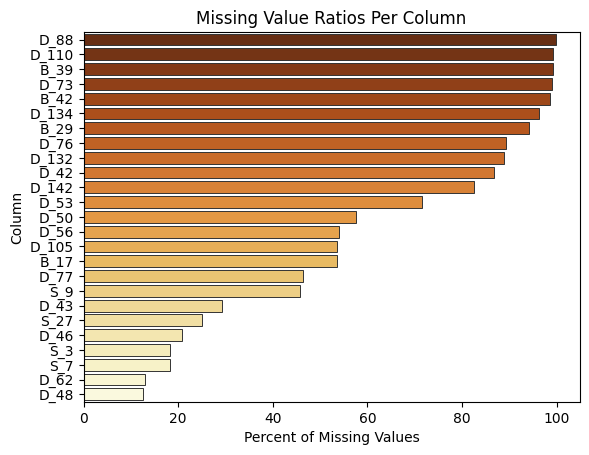

In [8]:
gc.collect()
miss =train_df.isna().sum().sort_values(ascending=False).reset_index(drop=False).rename({0:'missing_count'}, axis=1)
miss['miss_ratio'] = (miss['missing_count'] / train_df.shape[0]) * 100

sns.barplot(data=miss[:25], x= 'miss_ratio', y='index', palette='YlOrBr_r', linewidth=0.7, edgecolor=".2")
plt.title('Missing Value Ratios Per Column')
plt.ylabel('Column')
plt.xlabel('Percent of Missing Values')
del miss
plt.show()

## Missing Values

Purpose:
This cell handles missing values in the training data by removing columns with the most NaN values.

## Steps:
1. Manually trigger garbage collection using `gc.collect()` to free up memory.
2. Calculate the count of missing values for each column in the training data using `.isna().sum()`.
3. Sort the columns based on the count of missing values in descending order.
4. Get the names of the top 15 columns with the most NaN values.
5. Drop the columns with the most NaN values from the training data.


In [9]:
gc.collect()
missing_values = train_df.isna().sum()

# Sort columns based on missing values count
sorted_columns = missing_values.sort_values(ascending=False)

# Get names of top 20 columns with most NaN values
top_20_columns_with_most_nans = sorted_columns.head(15).index.tolist()
# Remove columns with most NaN values
train_df = train_df.drop(columns=top_20_columns_with_most_nans)


## Imputing Missing Values

Purpose:
This cell imputes missing values in the training data with the median for numerical columns.

## Steps:
1. Define `all_cols` containing all columns in the training data and `feature_cols` containing columns used as features.
2. Iterate over each column in `feature_cols`:
   - Check if the column is numerical (`dtype != 'object'`).
   - If the column is numerical, fill missing values with the median of that column using `.fillna(train_df[col].median())`.
3. Check for any remaining missing values after imputation using `isnull().sum()`.
Finally, we must deal with columns that have no value (Nan), simply by removing those rows

In [10]:
all_cols = train_df.columns
feature_cols = [col for col in all_cols if col not in non_use_cols]

# Impute missing values with median for each column in the feature columns
for col in feature_cols:
    if train_df[col].dtype != 'object':  # If the column is numerical
        train_df[col] = train_df[col].fillna(train_df[col].median())

# Check if there are any missing values left
print(train_df.isnull().sum())

S_2       0
P_2       0
D_39      0
B_1       0
B_2       0
         ..
D_141     0
D_143     0
D_144     0
D_145     0
target    0
Length: 175, dtype: int64


## Splitting Data into Features and Target

Purpose:
This cell splits the training data into features (X) and target (y) variables.

## Steps:
1. Copy the 'target' column from `train_df` to create the target variable `y`.
2. Select the feature columns (`feature_cols`) from `train_df` to create the feature variables `x`.

In [11]:
y = train_df['target'].copy()
x = train_df[feature_cols]

# Building a Model

## Training LightGBM Classifier with Progress Bar

Purpose:
This cell trains a LightGBM classifier with a progress bar to monitor training progress.

## Steps:
1. Manually trigger garbage collection using `gc.collect()` to free up memory.
2. Split the data into training and validation sets using `train_test_split`.
3. Create LightGBM datasets (`train_data` and `test_data`) from the training and validation sets.
4. Define parameters (`params`) for the LightGBM classifier.
5. Define a callback function (`callback_with_progress_bar`) to display training progress using tqdm.
6. Train the LightGBM model (`gbm`) with the progress bar using `fit`.
   - Set up evaluation sets, early stopping, log evaluation, and the custom callback function.
   - Monitor evaluation metrics including AUC and binary logloss.
Build a model using Random Forest to predict probability of Default or not.

In [12]:
import lightgbm as lgb
from tqdm.auto import tqdm
import time
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
import gc

# Appel de gc.collect() pour nettoyer la mémoire
gc.collect()

# Division des données en ensembles d'entraînement et de validation
Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(x, y, test_size=0.20, random_state=42)

# Création des ensembles de données pour LightGBM
train_data = lgb.Dataset(Xtrain, label=Ytrain)
test_data = lgb.Dataset(Xvalid, label=Yvalid, reference=train_data)

# Paramètres de LightGBM
params = {'boosting_type': 'gbdt',
          'n_estimators': 2000,
          'num_leaves': 50,
          'learning_rate': 0.05,
          'colsample_bytree': 0.9,
          'min_child_samples': 2000,
          'max_bins': 500,
          'reg_alpha': 2,
          'objective': 'binary',
          'random_state': 21}

# Fonction de rappel pour afficher la progression
def callback_with_progress_bar(num_iterations):
    def callback(env):
        iteration = env.iteration + 1
        if iteration == 1 or iteration % 10 == 0 or iteration == num_iterations:
            tqdm.write(f'[{time.strftime("%Y-%m-%d %H:%M:%S")}] Iteration: {iteration}, best_score: {env.model.best_score}')
    return callback

# Entraînement du modèle avec la barre de progression
gbm = LGBMClassifier(**params)
with tqdm(total=params['n_estimators'], desc="Training progress") as pbar:
    gbm.fit(Xtrain, Ytrain,
            eval_set=[(Xtrain, Ytrain), (Xvalid, Yvalid)],
            callbacks=[lgb.early_stopping(200), lgb.log_evaluation(500), callback_with_progress_bar(params['n_estimators']), lambda env: pbar.update(1)],
            eval_metric=['auc','binary_logloss'])


Training progress:   0%|          | 0/2000 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 188894, number of negative: 541270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.894883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40979
[LightGBM] [Info] Number of data points in the train set: 730164, number of used features: 169
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258701 -> initscore=-1.052732
[LightGBM] [Info] Start training from score -1.052732
[2024-04-14 11:10:40] Iteration: 1, best_score: {}
Training until validation scores don't improve for 200 rounds
[2024-04-14 11:10:47] Iteration: 10, best_score: {}
[2024-04-14 11:10:54] Iteration: 20, best_score: {}
[2024-04-14 11:11:01] Iteration: 30, best_score: {}
[2024-04-14 11:11:09] Iteration: 40, best_score: {}
[2024-04-14 11:11:16] Iteration: 50, best_score: {}
[2024-04-14 11:11:24] Iteration: 60, best_score: {}
[2024-04-14 11:11:32] Iteration: 70, best_score: {}
[2024-04-14 11:11:39] It

In [13]:
#%%time
#rfC = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=300))  
#del train_df
#del train_labels
#rfC.fit(x, y)

# Read Test Data and Predict

## Loading and Preprocessing Test Data

Purpose:
This cell loads the test data from a Parquet file, selects the latest statement date for each customer, sets the customer_ID as the index, and sorts the data by customer_ID.

## Steps:
1. Read the test data from the Parquet file using `pd.read_parquet`.
2. Group the data by 'customer_ID'.
3. Select the last row (latest statement date) for each customer using `groupby('customer_ID').tail(1)`.
4. Set 'customer_ID' as the index of the DataFrame and drop it from the columns using `set_index('customer_ID', drop=True)`.
5. Sort the DataFrame by 'customer_ID' using `sort_index()`.

In [14]:
test_df = pd.read_parquet('../input/amex-data-integer-dtypes-parquet-format/test.parquet').groupby('customer_ID').tail(1).set_index('customer_ID', drop=True).sort_index()
test_df

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
customer_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,2019-10-12,0.568930,4,0.010779,1.009347,0.000000,0.149413,0.000000,0.003576,0.103745,0.007398,0,9,0.025111,0.050187,0,0.445881,0.489448,0.517214,-1,0.024945,0.163441,1.008730,NaN,1,0.005263,1,0.115930,0.560515,0.033599,NaN,0.011795,0.005188,0,1.0,0,0.159703,0.058696,1454,0.458377,NaN,0.063506,0,0.381320,0.016998,0.008621,25,0.013835,0.589184,0.014091,49,0.049326,0,3,0,0,NaN,0.590569,0,-1,0,6,0.187650,0.002591,574,0.006617,0.008136,0,0,0.281546,0,6,0.147274,0.178798,0.964865,3,3,NaN,0.007062,0.0,NaN,0.005402,0.009328,0,0,0,-1,0.009269,0,0,0,0.000554,0,1,0.007410,1.0,0.140051,0,0,0.0,0,0,0,0.002720,0,0,0,-1,0,0,NaN,1,0.003337,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0.980107,0.135788,0.957597,0.970630,0.080587,0.003999,0,0.000000,NaN,-1,0,0.001118,0.007948,-1,1.002286,2,-1,0,NaN,-1,NaN,1.000000,0.375581,0.346436,0,0,0.251319,0,0,0.247260,0.253783,1,0.199254,1,0,1,0,1,0,0.000000,0,0,NaN,0.000000,0.000000,NaN,0.006273,0,NaN,-1,-1,-1,-1,0,0,0.000000,NaN,0,0.003690,0
00001bf2e77ff879fab36aa4fac689b9ba411dae63ae397d4263dafa1daedef5,2019-04-15,0.841177,4,0.016562,1.009245,0.000000,0.112195,0.000000,0.011386,NaN,NaN,0,1,0.099732,0.135907,0,0.445957,0.362383,0.041712,-1,0.182720,0.014466,1.008640,NaN,0,0.017454,0,0.143998,0.525659,0.298735,NaN,0.009336,0.002235,0,1.0,0,0.081717,0.054184,2402,0.053444,0.063766,0.058585,0,0.006375,0.018508,0.010847,34,0.685577,0.046726,0.005461,8,0.330806,3,0,0,1,NaN,1.000000,0,-1,0,6,0.190710,0.009712,290,0.004334,0.001395,0,0,0.010397,0,4,0.004756,NaN,0.000000,0,0,NaN,0.008168,0.0,0.302335,0.026572,0.005945,0,0,0,-1,0.005311,0,0,0,0.000172,0,-1,0.002403,1.0,0.008613,0,0,0.0,0,0,0,NaN,0,0,0,-1,0,0,NaN,1,0.008257,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.928590,0.135659,0.939332,0.974450,0.020564,0.007385,0,0.000000,NaN,-1,0,0.007424,0.012894,-1,1.000501,2,-1,0,NaN,-1,NaN,1.000000,0.005498,0.590974,0,1,0.317455,0,4,0.316734,0.318151,0,0.854850,4,0,15,0,2,0,0.999368,0,0,NaN,0.000000,0.000000,NaN,0.002767,0,NaN,-1,-1,-1,-1,0,0,0.000000,NaN,0,0.000247,0
0000210045da4f81e5f122c6bde5c2a617d03eef67f82c5e400fc98e7bd43ce8,2019-10-16,0.697522,0,0.001484,0.810072,0.000000,0.166165,0.000000,0.015938,NaN,0.105303,0,32,0.068810,0.004851,0,0.702994,0.204331,0.522954,-1,0.058534,0.090228,1.009375,NaN,0,0.008629,0,0.235105,0.566616,0.129189,NaN,0.004455,0.003380,0,1.0,0,0.170267,0.052914,379,0.418986,NaN,0.048129,0,0.272541,0.009170,0.004427,12,0.003803,0.508047,0.006497,27,0.520753,0,3,0,0,NaN,0.585974,0,1,0,4,0.185771,0.007611,0,0.007911,0.009446,0,1,0.044768,0,7,0.088291,NaN,0.000000,1,1,NaN,0.009076,0.0,0.482407,0.006430,0.000994,0,0,0,-1,0.001589,0,0,0,0.005905,0,1,0.009468,1.0,0.284616,0,0,0.0,0,0,0,0.001870,0,0,0,-1,0,0,NaN,1,0.005802,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.041972,0.133058,0.044327,0.970232,0.004460,0.336426,1,0.965

## Encoding Categorical Features in Test Data

Purpose:
This cell encodes the categorical features in the test data using the LabelEncoders from the training data.

## Steps:
1. Manually trigger garbage collection using `gc.collect()` to free up memory.
2. Iterate over each categorical feature (`cat_feature`) and its corresponding encoder (`encoder`) in `le_encoders`.
3. If the categorical feature is present in the test data columns, transform it using the encoder.
4. If the categorical feature is not found in the test data, print a message indicating its absence.


In [15]:
gc.collect()
for cat_feature, encoder in le_encoders.items():
    if cat_feature in test_df.columns:
        test_df[cat_feature] = encoder.transform(test_df[cat_feature].astype(str))
    else:
        print(f"{cat_feature} not found in test_df.")

## Preprocessing Test Data

Purpose:
This cell preprocesses the test data by imputing missing values with the median for numerical columns, converting the datetime column to Unix timestamp, scaling the datetime column, and dropping columns with the most missing values.

## Steps:
1. Impute missing values with the median for each numerical column in the feature columns using `.fillna(test_df[col].median())`.
2. Check if there are any remaining missing values after imputation using `isnull().sum()`.
3. Convert the datetime column ('S_2') to datetime format using `pd.to_datetime`.
4. Convert datetime values to Unix timestamp and then to integer using `astype('int64') // 10**9`.
5. Scale the datetime column using `scaler.fit_transform`.
6. Drop columns with the most missing values from the test data.Getting rid of Nans in test data

In [16]:

# Ensure you're operating on the original DataFrame by using .loc
for col in feature_cols:
    if test_df[col].dtype != 'object':  # If the column is numerical
        test_df.loc[:, col] = test_df.loc[:, col].fillna(test_df[col].median())

# Check if there are any missing values left
print(test_df.isnull().sum())

#We change the datetime:
test_df['S_2'] = pd.to_datetime(test_df['S_2'])
test_df['S_2'] = test_df['S_2'].astype('int64') // 10**9
date_int_scaledt = scaler.fit_transform(test_df[['S_2']])
test_df['S_2'] = date_int_scaledt

#Drop the columns with the most missing values
test_df = test_df.drop(columns=top_20_columns_with_most_nans)

S_2           0
P_2           0
D_39          0
B_1           0
B_2           0
          ...  
D_141         0
D_142    763770
D_143         0
D_144         0
D_145         0
Length: 189, dtype: int64


## Making Predictions on Test Data

Purpose:
This cell makes predictions on the test data using the trained LightGBM model (`gbm`).

## Steps:
1. Manually trigger garbage collection using `gc.collect()` to free up memory.
2. Predict the probabilities of the positive class (target = 1) for the test data using `gbm.predict_proba(test_df)[:, 1]`.


In [17]:
gc.collect()
y_pred = gbm.predict_proba(test_df)[:,1]
y_pred

array([0.02939473, 0.00175623, 0.02960819, ..., 0.35676836, 0.22918173,
       0.05116596])

## AMEX Metric Calculation

Purpose:
This cell defines a custom evaluation metric function called `amex_metric` as per the competition's requirements.

## Steps:
1. Define a function `top_four_percent_captured` to calculate the percentage of true positives captured within the top 4% of predictions.
2. Define a function `weighted_gini` to calculate the weighted Gini coefficient.
3. Define a function `normalized_weighted_gini` to calculate the normalized weighted Gini coefficient.
4. Calculate the AMEX metric by combining the normalized weighted Gini coefficient and the percentage of true positives captured.
5. Return the AMEX metric value.

In [18]:
#This is the metric we are asked to use
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.to_frame(name='prediction')
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

## Creating DataFrame for Predicted Probabilities

Purpose:
This cell creates a DataFrame containing the predicted probabilities for the positive class.

## Steps:
1. Create a DataFrame `df_y_pred` containing the predicted probabilities for the positive class (`y_pred`).



In [19]:
#df_y_pred = pd.DataFrame({"target0_prob": y_pred_proba[:, 0], "target1_prob": y_pred_proba[:, 1]})
df_y_pred=pd.DataFrame(y_pred)
df_y_pred

,0
0,0.029395
1,0.001756
2,0.029608
3,0.194422
4,0.900975
...,...
924616,0.016988
924617,0.768126
924618,0.356768
924619,0.229182


## Generating Submission File

Purpose:
This cell generates a submission file containing the predictions and saves it as a CSV file.

## Steps:
1. Read the sample submission file (`sample_submission.csv`) using `pd.read_csv`.
2. Add the predictions (`y_pred`) as a new column named "prediction" to the DataFrame `sub`.
3. Save the modified DataFrame as a CSV file named "submission6.csv" using `to_csv`.
4. Print the first few rows of the modified DataFrame.

In [20]:
sub = pd.read_csv('../input/amex-default-prediction/sample_submission.csv')
sub["prediction"] = y_pred
sub.to_csv('submission6.csv', index=False)
print(sub.head())

                                         customer_ID  prediction
0  00000469ba478561f23a92a868bd366de6f6527a684c9a...    0.029395
1  00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...    0.001756
2  0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...    0.029608
3  00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...    0.194422
4  00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...    0.900975
